# 19 Evaluating Causal Models

- causal model은 ml model과 다르게 train-test paradigm을 적용하기 어렵다.
- causal inference라는 것은 unobservable quantity를 estimating해야하기 때문이다.
- 하지만 use aggregate measurements of elasticity 으로 개별적으로는 어려워도 group단위로 해볼 수 있지 않을까

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from toolz import curry

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings("ignore")

- non random data(treatment not random)와 random data를 이용해서 causal model을 evaluating해보자.
- 모델 훈련은 non random data로 하지만 평가는 random data로 한다.

In [3]:
prices = pd.read_csv("./data/ice_cream_sales.csv") # loads non-random data
prices_rnd = pd.read_csv("./data/ice_cream_sales_rnd.csv") # loads random data
print(prices_rnd.shape)
prices.head()

(5000, 5)


,temp,weekday,cost,price,sales
0,17.3,6,1.5,5.6,173
1,25.4,3,0.3,4.9,196
2,23.3,5,1.5,7.6,207
3,26.9,1,0.3,5.3,241
4,20.2,1,1.0,7.2,227


- 먼저, 2개 모델을 만들어보자.
  - 하나는 이전에 linear regression의 interaction term을 이용해서 elasticity를 구하는 모델
  - 하나는 fully nonparametric ML predictive 모델

$$sales_i = \beta_0 + \beta_1 price_i + \pmb{\beta_2 X}_i + \pmb{\beta_3 X}_i price_i + e_i$$

$$sales_i = G(X_i, price_i) + e_i$$

- 훈련은 non random data로 진행한다.

In [4]:
m1 = smf.ols("sales ~ price*cost + price*C(weekday) + price*temp", data=prices).fit()

In [5]:
X = ["temp", "weekday", "cost", "price"]
y = "sales"

np.random.seed(1)
m2 = GradientBoostingRegressor()
m2.fit(prices[X], prices[y]);

- 이제 random data를 이용하여 예측해보자.
- elasticity prediction, ML prediction, random prediction 3가지를 구한다.

In [6]:
def predict_elast(model, price_df, h=0.01):
    return (model.predict(price_df.assign(price=price_df["price"]+h))
            - model.predict(price_df)) / h

np.random.seed(123)
prices_rnd_pred = prices_rnd.assign(**{
    "elast_m_pred": predict_elast(m1, prices_rnd), ## elasticity model
    "pred_m_pred": m2.predict(prices_rnd[X]), ## predictive model
    "rand_m_pred": np.random.uniform(size=prices_rnd.shape[0]), ## random model
})

prices_rnd_pred.head()

,temp,weekday,cost,price,sales,elast_m_pred,pred_m_pred,rand_m_pred
0,25.8,1,0.3,7,230,-13.096964,224.067406,0.696469
1,22.7,3,0.5,4,190,1.054695,189.889147,0.286139
2,33.7,7,1.0,5,237,-17.362642,237.255157,0.226851
3,23.0,4,0.5,5,193,0.564985,186.688619,0.551315
4,24.4,1,1.0,3,252,-13.717946,250.342203,0.719469


## Elasticity by Model Band

- 우리는 true elasticity를 모르기 때문에 바로 evaluate할수는 없다.
- 그렇다면 우리의 목표가 무엇인지 다시 생각해보자.
  - 우리는 finding which units are more sensitive to the treatment and which are less 하고 싶다.
  - 어떤 날에 ice cream에 돈을 더 쓸지 구분해야하는 것이다. (price elasticity less negative)
- 개별 unit의 elasticity를 알수는 없지만 group으로는 볼 수 있지 않을까?
  - treatment가 random이라면 group별로 treated와 untreated outcome을 비교하면 된다.
  - 즉, pred elasticity를 크기에 따라 ordering하여 group화하고 각 group마다 treated와 untreated의 outcome을 비교해본다.
  - 그러면 elasticity가 큰 그룹일수록 outcome의 차이가 커야하고 그러면 우리가 model을 잘 만들었다고 할 수 있는 것이고 이를 통해 personalization을 잘 할 수 있다는 것이다.

- 데이터를 통해 이해해보자.
- 먼저 각 group별로 linear regression model을 이용해서 elasticity를 구해보자. (continous case)

$$y_i = \beta_0 + \beta_1t_i + e_i$$

$$\hat{\beta_1}=\dfrac{\sum (t_i - \bar{t}) (y_i - \bar{y})}{\sum(t_i - \bar{t})^2}$$


In [7]:
@curry
def elast(data, y, t):
        # line coeficient for the one variable linear regression 
        return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
                np.sum((data[t] - data[t].mean())**2))

- 동일한 크기로 ordering한 unit을 그룹화한다.

In [8]:
def elast_by_band(df, pred, y, t, bands=10):
    return (df
            .assign(**{f"{pred}_band":pd.qcut(df[pred], q=bands)}) # makes quantile partitions
            .groupby(f"{pred}_band")
            .apply(elast(y=y, t=t))) # estimate the elasticity on each partition

In [21]:
elast_by_band(prices_rnd_pred, 'elast_m_pred', "sales", "price")

elast_m_pred_band
(-18.778000000000002, -14.073]   -11.749212
(-14.073, -12.538]                -9.848638
(-12.538, -4.218]                 -7.872637
(-4.218, -1.941]                   2.150171
(-1.941, -1.103]                   1.308599
(-1.103, -0.421]                   0.526033
(-0.421, 0.217]                    0.279641
(0.217, 0.898]                    -0.289010
(0.898, 1.693]                    -0.666963
(1.693, 5.565]                    -1.958290
dtype: float64

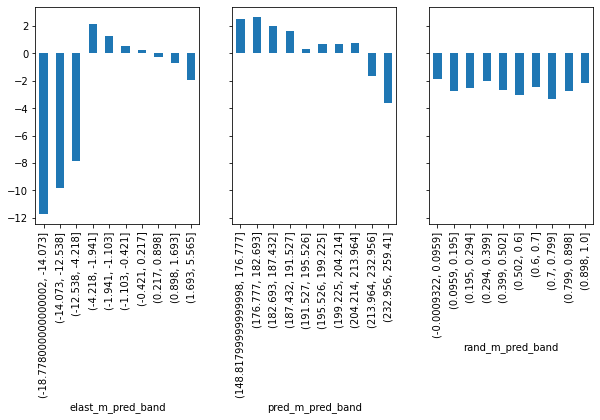

In [9]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(10, 4))
for m, ax in zip(["elast_m_pred", "pred_m_pred", "rand_m_pred"], axs):
    elast_by_band(prices_rnd_pred, m, "sales", "price").plot.bar(ax=ax)

- 먼저 random model은 예상대로 estimated elasticity가 거의 동일하다.
  - personalization에는 도움을 주지 못한다.
- 다음은 pred ML model을 보면 순서대로 잘 만들어졌다. group별로 elasticity가 잘 ordering되어 있다.
- 마지막으로 causal model을 보자. 이 모델도 잘 만들어졌다. sensitive정도에 따라 그룹이 잘 구분되어 있다.

## Cumulative Elasticity Curve

- cumulative elasticity (as the elasticity estimated up until unit $k$)

$$\widehat{y'(t)}_k = \hat{\beta_1}_k=\dfrac{\sum_i^k (t_i - \bar{t}) (y_i - \bar{y})}{\sum_i^k(t_i - \bar{t})^2}$$

In [10]:
def cumulative_elast_curve(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    
    # orders the dataset by the `prediction` column
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    
    # create a sequence of row numbers that will define our Ks
    # The last item is the sequence is all the rows (the size of the dataset)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    
    # cumulative computes the elasticity. First for the top min_periods units.
    # then for the top (min_periods + step*1), then (min_periods + step*2) and so on
    return np.array([elast(ordered_df.head(rows), y, t) for rows in n_rows])

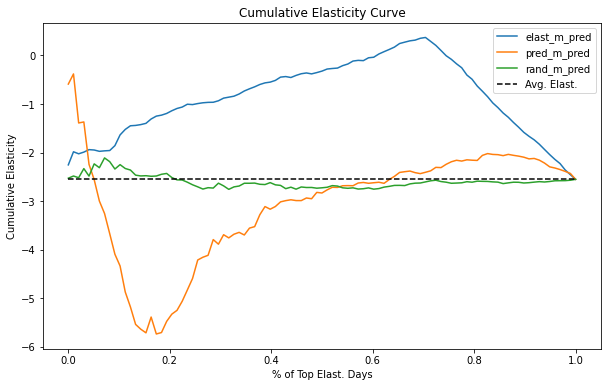

In [11]:
plt.figure(figsize=(10,6))

for m in ["elast_m_pred", "pred_m_pred", "rand_m_pred"]:
    cumu_elast = cumulative_elast_curve(prices_rnd_pred, m, "sales", "price", min_periods=100, steps=100)
    x = np.array(range(len(cumu_elast)))
    plt.plot(x/x.max(), cumu_elast, label=m)

plt.hlines(elast(prices_rnd_pred, "sales", "price"), 0, 1, linestyles="--", color="black", label="Avg. Elast.")
plt.xlabel("% of Top Elast. Days")
plt.ylabel("Cumulative Elasticity")
plt.title("Cumulative Elasticity Curve")
plt.legend();

- 해석이 쉽니는 않다.
- 먼저, `pred_m`의 경우 다소 빠르게 average elasticity로 수렴한다.
- `elast_m`은 75%까리 상승한다.

## Cumulative Gain Curve

- cumulative elasticity에 propotional sample size를 곱한다.

$$\widehat{F(t)}_k = \hat{\beta_1}_k * \frac{k}{N} =\dfrac{\sum_i^k (t_i - \bar{t}) (y_i - \bar{y})}{\sum_i^k(t_i - \bar{t})^2} * \frac{k}{N}$$

In [12]:
def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    
    ## add (rows/size) as a normalizer. 
    return np.array([elast(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

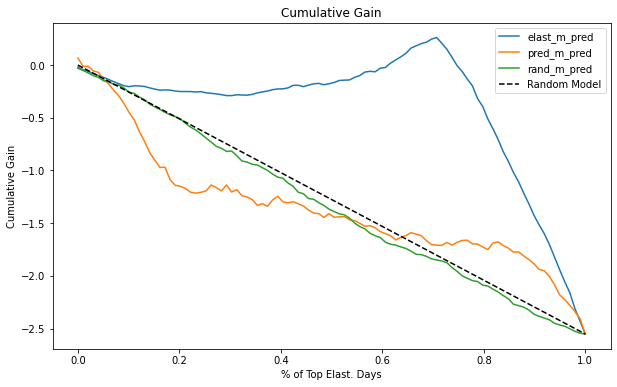

In [13]:
plt.figure(figsize=(10,6))

for m in ["elast_m_pred", "pred_m_pred", "rand_m_pred"]:
    cumu_gain = cumulative_gain(prices_rnd_pred, m, "sales", "price", min_periods=50, steps=100)
    x = np.array(range(len(cumu_gain)))
    plt.plot(x/x.max(), cumu_gain, label=m)
    
plt.plot([0, 1], [0, elast(prices_rnd_pred, "sales", "price")], linestyle="--", label="Random Model", color="black")

plt.xlabel("% of Top Elast. Days")
plt.ylabel("Cumulative Gain")
plt.title("Cumulative Gain")
plt.legend();

- `elast_m` 모델이 가장 좋아보인다.
- personalisation에 가장 좋을 것이다.
- random model은 0부터 ATE까지의 직선을 의미한다.

## Taking Variance Into Account

$$s_{\hat\beta_1}=\sqrt{\frac{\sum_i\hat\epsilon_i^2}{(n-2)\sum_i(t_i-\bar t)^2}}$$

In [14]:
def elast_ci(df, y, t, z=1.96):
    n = df.shape[0]
    t_bar = df[t].mean()
    beta1 = elast(df, y, t)
    beta0 = df[y].mean() - beta1 * t_bar
    e = df[y] - (beta0 + beta1*df[t])
    se = np.sqrt(((1/(n-2))*np.sum(e**2))/np.sum((df[t]-t_bar)**2))
    return np.array([beta1 - z*se, beta1 + z*se])

In [15]:
def cumulative_elast_curve_ci(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    
    # just replacing a call to `elast` by a call to `elast_ci`
    return np.array([elast_ci(ordered_df.head(rows), y, t)  for rows in n_rows])

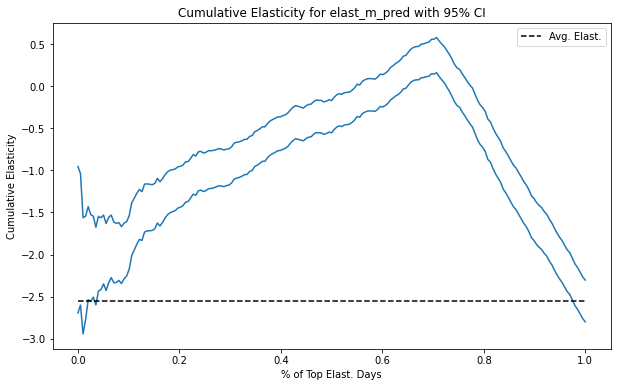

In [16]:
plt.figure(figsize=(10,6))

cumu_gain_ci = cumulative_elast_curve_ci(prices_rnd_pred, "elast_m_pred", "sales", "price", min_periods=50, steps=200)
x = np.array(range(len(cumu_gain_ci)))
plt.plot(x/x.max(), cumu_gain_ci, color="C0")

plt.hlines(elast(prices_rnd_pred, "sales", "price"), 0, 1, linestyles="--", color="black", label="Avg. Elast.")

plt.xlabel("% of Top Elast. Days")
plt.ylabel("Cumulative Elasticity")
plt.title("Cumulative Elasticity for elast_m_pred with 95% CI")
plt.legend();

In [17]:
def cumulative_gain_ci(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    return np.array([elast_ci(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

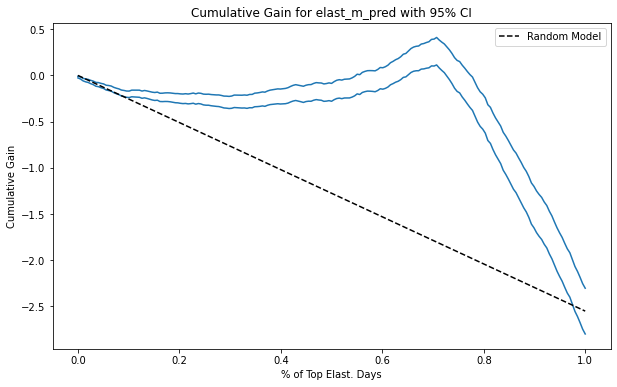

In [18]:
plt.figure(figsize=(10,6))

cumu_gain = cumulative_gain_ci(prices_rnd_pred, "elast_m_pred", "sales", "price", min_periods=50, steps=200)
x = np.array(range(len(cumu_gain)))
plt.plot(x/x.max(), cumu_gain, color="C0")

plt.plot([0, 1], [0, elast(prices_rnd_pred, "sales", "price")], linestyle="--", label="Random Model", color="black")

plt.xlabel("% of Top Elast. Days")
plt.ylabel("Cumulative Gain")
plt.title("Cumulative Gain for elast_m_pred with 95% CI")
plt.legend();